In [ ]:
import sys, os
import time
import pandas as pd
import numpy as np
sys.path.append('')
from units.models import ModelTrainer
from units.unit import load_data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


y_type = 'ddG_kcal_mol'


local_descriptors = pd.read_csv('all_descriptor.csv',index_col='name')
local_descriptors = local_descriptors.drop(columns=['HOMO','HOMO_number', 'LUMO', 'HOMO_LUMO_Gap'])
combined_descriptors = pd.concat([local_descriptors], axis=1)

data = combined_descriptors
data_y = pd.read_csv('dG_ddG_PXP_cat_ts.csv', index_col=0)

data = data.loc[data_y.index]

y = data_y[y_type]

nan_columns = data.columns[data.isnull().any()].tolist()
constant_columns = data.columns[data.nunique() == 1].tolist()

columns_to_drop = list(set(nan_columns + constant_columns))
if columns_to_drop:

    print(f"⚠️ Warning: Found {len(columns_to_drop)} problematic feature columns that need to be removed.")

    if nan_columns:
        print(f"  - {len(nan_columns)} columns contain NaN values: {nan_columns}")
    if constant_columns:
        print(f"  - {len(constant_columns)} columns are constant: {constant_columns}")
    
    data = data.drop(columns=columns_to_drop)

cols = data.columns

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(data), 
                index=y.index, 
                columns=cols)

corr = X.corr().abs()
keep = []
for i in range(len(corr.columns)):
    above = corr.iloc[:i,i]
    if keep: above = above[keep]
    if all(above < 0.95):
        keep.append(corr.columns[i])
X = X[keep]
print(f"Data shape after removing highly correlated features: {X.shape}")

⚠️ Warning: Found 11 problematic feature columns that need to be removed.
  - 2 columns contain NaN values: ['Mayer_Bo', 'Atom_connec']
  - 9 columns are constant: ['IP_shift', 'EA_shift', 'h_shell_f', 'l_shell_f', 'Pop_type_f_Au_1', 'Pop_type_f_Au_2', 'Pop_type_d_C', 'Pop_type_f_C', 'Pop_type_f_I']
Data shape after removing highly correlated features: (138, 139)


In [2]:
condition = y.index.str.startswith('di_pn')
y_onehot = pd.Series(np.where(condition, 0, 1), index=y.index, name='class_label')

After feature selection, the number of remaining features is: 139
Correlation heatmap...

--- Top 10 Features Most Correlated with Target (Total_Energy_kcal_mol) ---
pyr_p_Au_1          0.705195
Atom_d_m_Z_Au_1     0.703577
Atom_d_m_I          0.679963
Bond_Au_I           0.675117
Hirshfeld_c_Au_1    0.668627
c_CM5_Au1           0.664596
pyr_p_I             0.663890
Atom_d_m_X_Au_1     0.650499
pyr_p_C             0.594956
Angle_C_Au_I        0.587722
Name: ddG_kcal_mol, dtype: float64


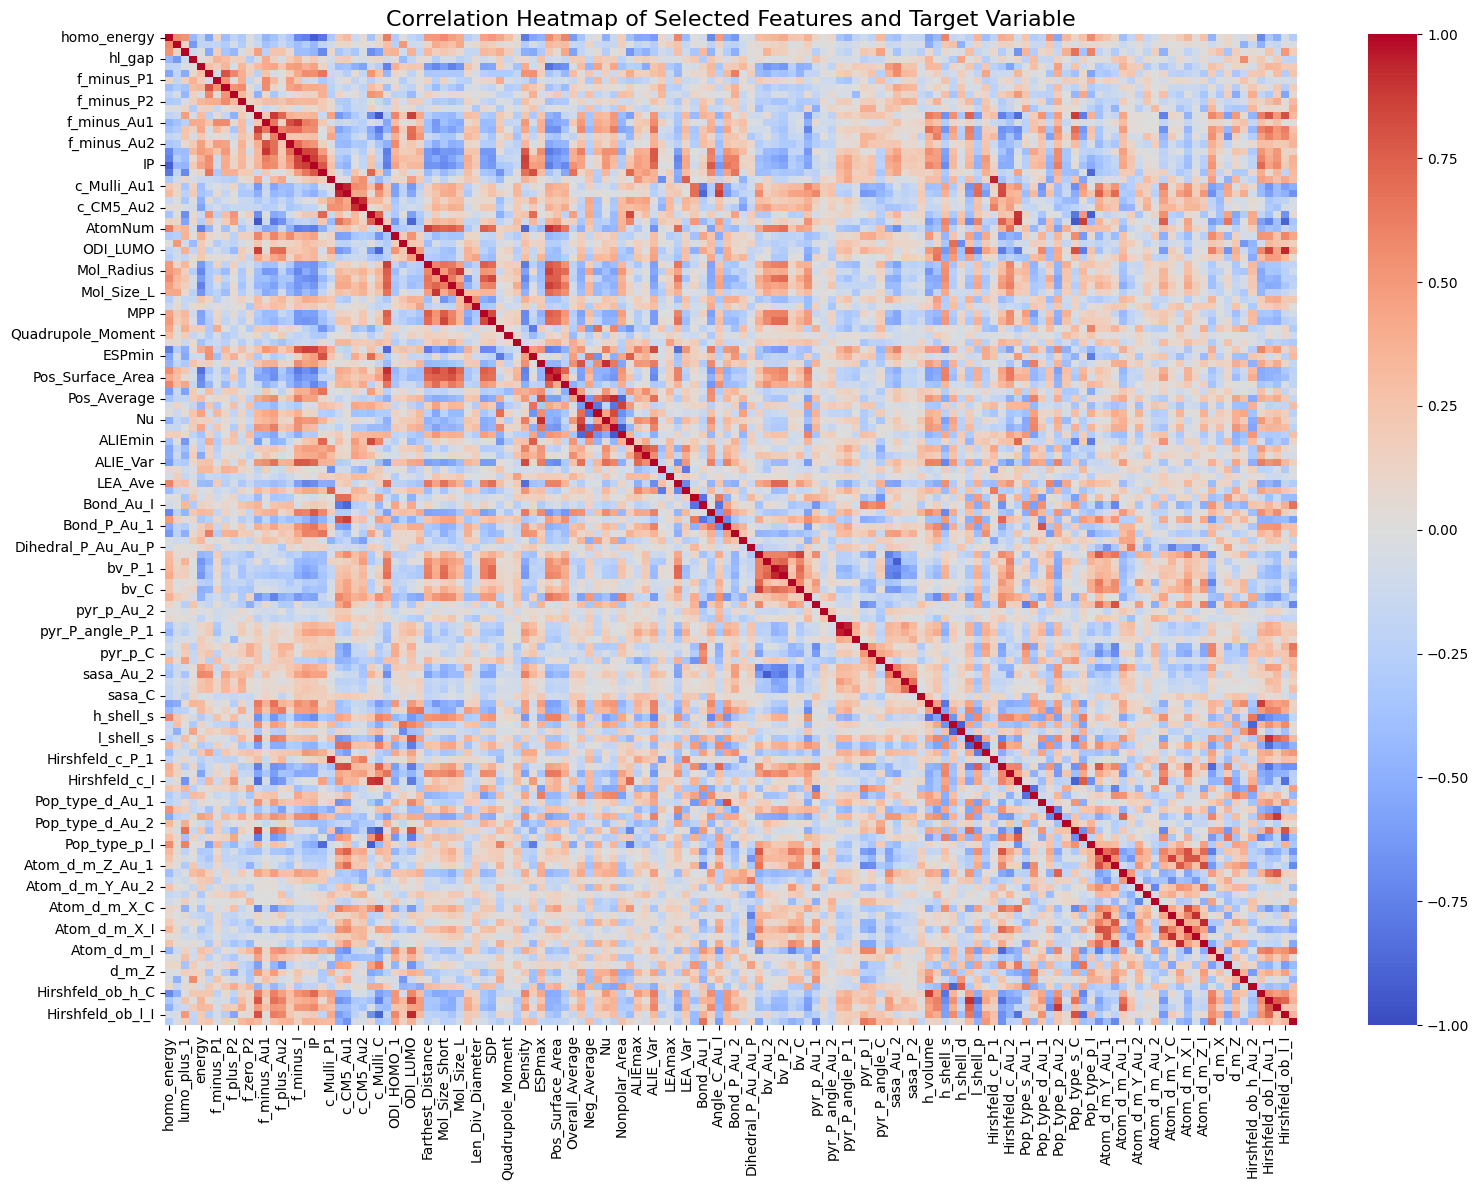

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print(f"After feature selection, the number of remaining features is: {X.shape[1]}")

data_for_corr = pd.concat([X, y], axis=1)

correlation_matrix = data_for_corr.corr()
print("Correlation heatmap...")


plt.figure(figsize=(16, 12)) 

heatmap = sns.heatmap(correlation_matrix, 
                      cmap='coolwarm', 
                      annot=False, 
                      vmin=-1, vmax=1)

plt.title('Correlation Heatmap of Selected Features and Target Variable', fontsize=16)

target_correlations = correlation_matrix[y_type].drop(y_type)
print("\n--- Top 10 Features Most Correlated with Target (Total_Energy_kcal_mol) ---")
print(target_correlations.abs().sort_values(ascending=False).head(10))

plt.tight_layout()
plt.show()


In [4]:
top10_feature = target_correlations.abs().sort_values(ascending=False).head(10).index.tolist
top10_feature

<bound method IndexOpsMixin.tolist of Index(['pyr_p_Au_1', 'Atom_d_m_Z_Au_1', 'Atom_d_m_I', 'Bond_Au_I',
       'Hirshfeld_c_Au_1', 'c_CM5_Au1', 'pyr_p_I', 'Atom_d_m_X_Au_1',
       'pyr_p_C', 'Angle_C_Au_I'],
      dtype='object')>

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np



X_to_train, X_to_test, y_to_train, y_to_test = train_test_split(X, y, test_size=0.2, random_state=42)



forensic_model = LinearRegression()
forensic_model.fit(X_to_train, y_to_train)


predictions = forensic_model.predict(X_to_test)

residuals = y_to_test - predictions

r2_forensic = forensic_model.score(X_to_test, y_to_test)
max_abs_error = np.max(np.abs(residuals))

print(f"R² score on the test set: {r2_forensic:.4f}")
print(f"Maximum absolute error (residual): {max_abs_error:.4e}")

coefficients = pd.Series(forensic_model.coef_, index=X_to_train.columns).abs().sort_values(ascending=False)
print(coefficients.head(15))



R² score on the test set: -2.1741
Maximum absolute error (residual): 1.3012e+01
h_volume            43.277476
Atom_d_m_I          42.126369
Atom_d_m_X_I        32.803229
Hirshfeld_ob_h_C    32.480604
Atom_d_m_X_Au_2     30.258082
Bond_Au_I           28.545359
bv_Au_2             28.210740
Hirshfeld_c_Au_1    27.365896
bv_P_2              26.256367
AtomNum             22.676135
Atom_d_m_Y_I        20.606821
Atom_d_m_Z_Au_1     20.367613
Pop_type_p_I        20.265094
Overall_Variance    18.975218
Atom_d_m_Y_Au_1     18.842001
dtype: float64


/root/software/anaconda3/envs/fyl/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.496e-02, tolerance: 5.559e-02
  model = cd_fast.enet_coordinate_descent(
/root/software/anaconda3/envs/fyl/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.065e-02, tolerance: 5.559e-02
  model = cd_fast.enet_coordinate_descent(
/root/software/anaconda3/envs/fyl/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

                                       feature_names avg_score  num_features
1                                      (pyr_p_Au_1,)  0.551034             1
2                         (Angle_C_Au_I, pyr_p_Au_1)   0.60875             2
3      (Farthest_Distance, Angle_C_Au_I, pyr_p_Au_1)  0.625928             3
4  (Farthest_Distance, Bond_Au_C, Angle_C_Au_I, p...  0.644418             4
5  (c_CM5_Au2, Farthest_Distance, Bond_Au_C, Angl...  0.656675             5
...
                                         feature_names avg_score  num_features
135  (homo_energy, lumo_energy, lumo_plus_1, hl_gap...  0.620352           135
136  (homo_energy, lumo_energy, lumo_plus_1, hl_gap...  0.614236           136
137  (homo_energy, lumo_energy, lumo_plus_1, hl_gap...  0.609459           137
138  (homo_energy, lumo_energy, lumo_plus_1, hl_gap...  0.600822           138
139  (homo_energy, lumo_energy, lumo_plus_1, hl_gap...  0.590044           139

Best number of features: 22
Best cross-validation R²: 0.761

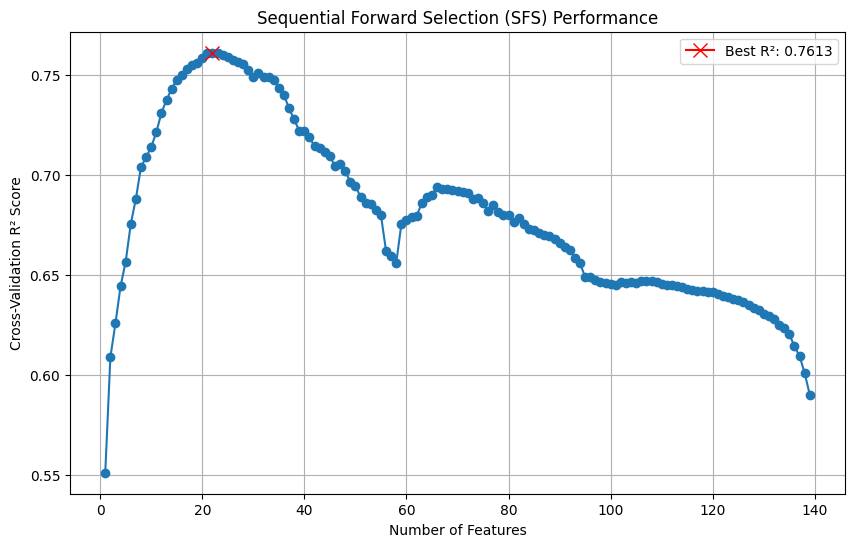


Final R² on test set using best feature set: 0.5830


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = ElasticNetCV(cv=5, random_state=42)

sfs = SFS(estimator=lr, 
          k_features=(1, X_train.shape[1]),
          forward=True,
          floating=False,
          scoring='r2',  
          cv=5,           
          n_jobs=-1)

sfs = sfs.fit(X_train, y_train)

sfs_results = pd.DataFrame.from_dict(sfs.subsets_).T
sfs_results = sfs_results[['feature_names', 'avg_score']]
sfs_results['num_features'] = sfs_results.index

print(sfs_results.head())
print("...")
print(sfs_results.tail())


best_k = sfs.k_feature_idx_
best_score = sfs.k_score_
best_features = sfs.k_feature_names_

print(f"\nBest number of features: {len(best_features)}")
print(f"Best cross-validation R²: {best_score:.4f}")
print(f"Best feature combination: {best_features}")


fig, ax = plt.subplots(figsize=(10, 6))


ax.plot(sfs_results['num_features'], sfs_results['avg_score'], marker='o')


best_num_features = len(best_features)
ax.plot(best_num_features, best_score, marker='x', markersize=10, color='red', label=f'Best R²: {best_score:.4f}')


ax.set_xlabel("Number of Features")
ax.set_ylabel("Cross-Validation R² Score")
ax.set_title("Sequential Forward Selection (SFS) Performance")
ax.grid(True)
ax.legend()
plt.show()

X_train_best = X_train[list(best_features)]
X_test_best = X_test[list(best_features)]

final_model = ElasticNetCV(cv=5, random_state=42)
final_model.fit(X_train_best, y_train)

test_r2 = final_model.score(X_test_best, y_test)

print(f"\nFinal R² on test set using best feature set: {test_r2:.4f}")

In [7]:
sfs_results

,feature_names,avg_score,num_features
1,"(pyr_p_Au_1,)",0.551034,1
2,"(Angle_C_Au_I, pyr_p_Au_1)",0.60875,2
3,"(Farthest_Distance, Angle_C_Au_I, pyr_p_Au_1)",0.625928,3
4,"(Farthest_Distance, Bond_Au_C, Angle_C_Au_I, p...",0.644418,4
5,"(c_CM5_Au2, Farthest_Distance, Bond_Au_C, Angl...",0.656675,5
...,...,...,...
135,"(homo_energy, lumo_energy, lumo_plus_1, hl_gap...",0.620352,135
136,"(homo_energy, lumo_energy, lumo_plus_1, hl_gap...",0.614236,136
137,"(homo_energy, lumo_energy, lumo_plus_1, hl_gap...",0.609459,137
138,"(homo_energy, lumo_energy, lumo_plus_1, hl_gap...",0.600822,138


In [8]:
sfs_results.loc[10]

feature_names    (c_CM5_Au2, Farthest_Distance, Mol_Size_Short,...
avg_score                                                 0.714102
num_features                                                    10
Name: 10, dtype: object

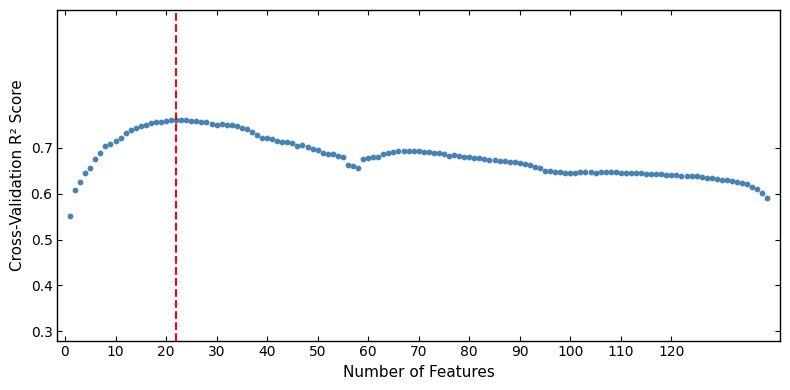

In [9]:
plt.figure(figsize=(8, 4))

plt.scatter(range(1, 140), sfs_results['avg_score'], color='#4682B4', s=10, marker='o')

plt.xlabel("Number of Features", fontsize=11)
plt.ylabel(("Cross-Validation R² Score"), fontsize=11)

plt.xticks(np.arange(0, 130, 10), fontsize=10)
plt.yticks(np.arange(0.3, 0.8, 0.1), fontsize=10)

plt.xlim(-1.5, 141.5)
plt.ylim(0.28, 1.0)

ax = plt.gca() 
ax.tick_params(direction='in', top=True, right=True, which='both')

best_num_features = len(best_features)
ax.axvline(x=best_num_features, color='red', linestyle='--', linewidth=1.5, 
           label=f'Best R²: {best_score:.4f}')

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)


plt.tight_layout()
plt.show()

In [10]:
sfs_results.loc[10]['feature_names']

('c_CM5_Au2',
 'Farthest_Distance',
 'Mol_Size_Short',
 'Bond_Au_C',
 'Angle_C_Au_I',
 'bv_P_1',
 'bv_P_2',
 'pyr_p_Au_1',
 'sasa_P_1',
 'sasa_P_2')